In this notebook, we provide an example of using the kernel ridge (KR) regression model for discount curve estimation using U.S. Treasury data. This notebook runs on Google Colab.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps 
import time
import os

# dir_kr = './code&data/'
# parent_dir_initial = os.getcwd()
# sys.path.append(dir_kr+'/src')
if('src' not in os.getcwd()):
    parent_dir = os.getcwd()
    os.chdir(parent_dir+'/src')
# os.getcwd()
import kr_model
import kr_utils
import nelsonsiegelsvensson

# Generating kernel matrix
KR has three hyper-parameters: $\alpha$, $\delta$, and $\lambda$, among which $\alpha$ and $\delta$ are shape hyper-parameters that determine the kernel matrix. For a fixed pair of $\alpha$ and $\delta$, we need to generate a kernel matrix only once, which can be shared across multiple cross-sections. $\lambda$ controls the degree of smoothness and model complexity. Baseline values for these three hyper-parameters are $\alpha=0.05$, $\delta=0$, and $\lambda=1$.

In this example, we generate a kernel matrix of dimension $N$-by-$N$, where $N$ is the maximum time-to-maturity of the discount curve that we are about to estimate. $N$ needs to be no less than the maximum time-to-maturity in days $N'$ of securities in the data so that pricing error can be calculated. When $N>N'$, we also obtain extrapolated curve estimates.

In [39]:
### settings
# kernel hyper-parameters
alpha=0.05
delta=0.00
    

# max time to maturity in days
N=30*365

start_time=time.time()
K=kr_model.generate_kernel_matrix(alpha, delta, N, N)
end_time=time.time()

print('Time elapsed for generating a {}-by-{} kernel matrix with alpha = {} and delta = {}: {:.1f} sec'\
      .format(N,N,alpha, delta, end_time-start_time))

Time elapsed for generating a 10950-by-10950 kernel matrix with alpha = 0.05 and delta = 0.0: 2.7 sec


# Load data

Price and cashflow data are contained in vector $B$ of dimension $M$ and matrix $C$ of dimension $M$-by-$N'$. $M$ is the number of securities in the cross-section. $N'$ is the maximum time-to-maturity in days of the data. For example, assume that there are three securities with prices 0.99, 0.98, and 0.97 maturing in 1, 3, and 5 days. Each of these securities has only one cash flow with value 1 due at maturity. Then, $B$ and $C$ take the following form:

$$B =
\begin{pmatrix}
0.99\\
0.98\\
0.97
\end{pmatrix}, 
$$

$$
C = 
\begin{pmatrix}
1 & 0 & 0 & 0& 0\\
0 & 0 & 1 & 0& 0\\
0 & 0 & 0 & 0& 1\\
\end{pmatrix}.
$$

In this example, $M=3$ and $N'=5$.

In the code block below, we load price vectors and cashflow matrices on two example dates: 1961-06-30 and 2013-12-31. We also calculate yield-to-maturity (YTM) and duration of observations so that we can compute weight vector $\omega$, which is used for weighing individual securities.

In [40]:
### load example data

dir_data=parent_dir+'/example_data/'
example_dates=['1961-06-30', '2013-12-31']

start_time=time.time()

dict_data={}
for date in example_dates:
    # load price vector and cashflow matrix
    B=np.load(dir_data+'price_{}.npy'.format(date))
    C=sps.load_npz(dir_data+'cashflow_{}.npz'.format(date)).toarray()
    M=B.shape[0]
    
    print('Date: {}; Number of securities: {}'.format(date, M))
    
    # get YTM and duration
    ytm, dur=np.zeros(M), np.zeros(M) # YTM and duration
    ttm = np.zeros(M) # time to maturity in days
    for i in range(M):
        time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
        ytm[i], dur[i] = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1], time_to_cashflow_inday, B[i])
        ttm[i] = max(time_to_cashflow_inday)

    # get inverse of weights for fitting
    # weights w is computed as w=1/inv_w
    inv_w=(dur*B)**2*M
    
    dict_data[date]={'B':B, 'C':C, 'ytm':ytm, 'dur':dur, 'ttm':ttm, 'inv_w':inv_w}
    
end_time=time.time()

print('Time elapsed for loading and preparing data for {} example dates: {:.1f} sec'\
      .format(len(example_dates),end_time-start_time))

Date: 1961-06-30; Number of securities: 50
Date: 2013-12-31; Number of securities: 280
Time elapsed for loading and preparing data for 2 example dates: 0.3 sec


In [4]:
# dict_data["2013-12-31"]["ttm"]/365

In [5]:
dict_data["2013-12-31"]["C"].shape

(280, 10727)

In [6]:
dict_data["1961-06-30"]["C"].shape

(50, 2511)

### Visualizing price data on example dates

In the plots below, we scatter prices and implied yield-to-maturity against time-to-maturity of securities in the example data. 

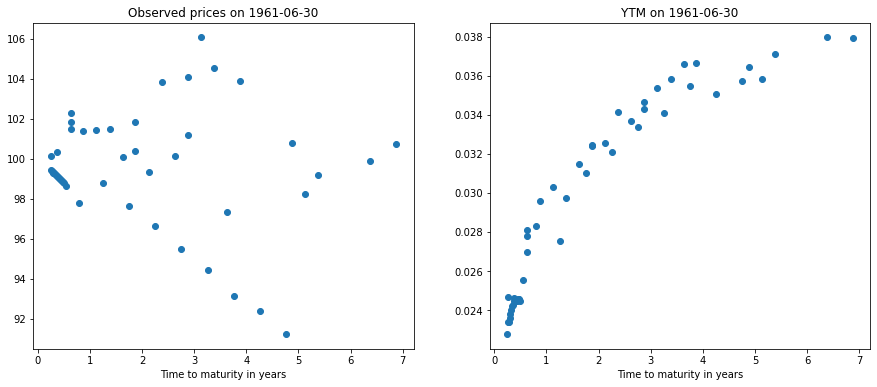

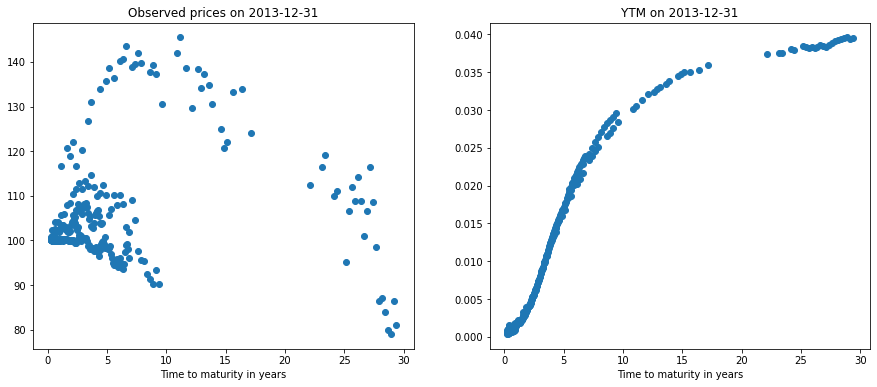

In [7]:
for date in example_dates:

    B=dict_data[date]['B']
    ttm=dict_data[date]['ttm']
    ytm=dict_data[date]['ytm']

    fig=plt.figure(figsize=(15,6))
    ax_1,ax_2=fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
    
    ax_1.scatter(ttm/365, B)
    ax_2.scatter(ttm/365, ytm)
    
    ax_1.set_title('Observed prices on {}'.format(date))
    ax_2.set_title('YTM on {}'.format(date))
    
    for ax in [ax_1, ax_2]:
        ax.set_xlabel('Time to maturity in years');

### Visualizing cashflow matrices on example dates

We visualize cashflow matrices on example dates in the following code block. The horizontal axis corresponds to time to cashflow in years, and the vertical axis shows indexes of securities on each example date. Intensity of color corresponds to the amount of cashflow payment. 

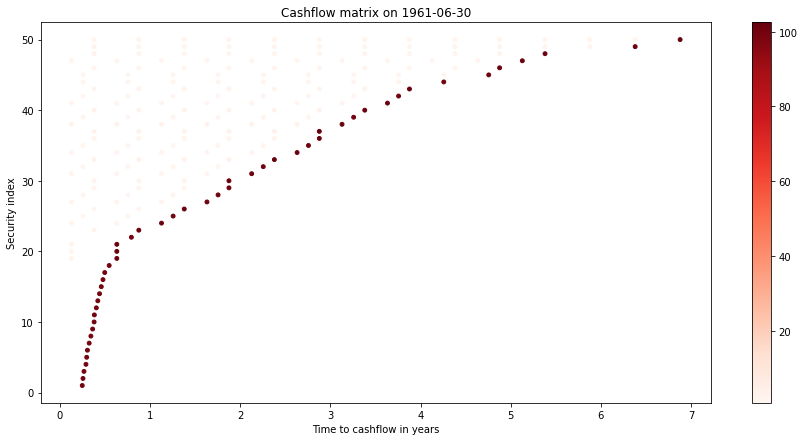

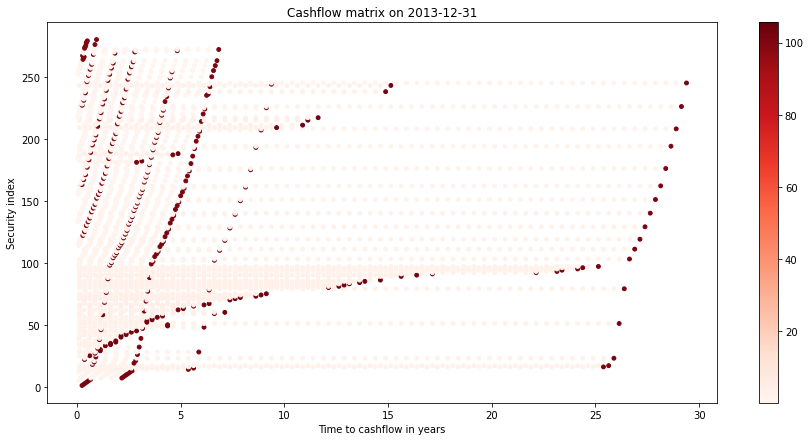

In [8]:
for date in example_dates:

    B=dict_data[date]['B']
    C=dict_data[date]['C']
    M=B.shape[0]

    time_to_cashflow_inday=[]
    for i in range(M):
        time_to_cashflow_inday.append(np.where(C[i]!=0)[0]+1)

    xs=np.concatenate(time_to_cashflow_inday)
    ys=np.concatenate([i* np.ones(time_to_cashflow_inday[i].shape) for i in range(M)])
    color=np.concatenate([C[i, time_to_cashflow_inday[i]-1] for i in range(M)])


    fig=plt.figure(figsize=(15,7))
    ax=fig.add_subplot(1,1,1)
    im = ax.scatter(x=xs/365, y=1+ys, c=color, cmap='Reds', alpha=1, s=15)
    fig.colorbar(im,ax=ax)


    ax.set_xlabel('Time to cashflow in years');
    ax.set_ylabel('Security index');
    ax.set_title('Cashflow matrix on {}'.format(date));


# Fit KR model on example dates

Once we've generated the kernel matrix and formatted input data, fitting KR is fast. The KR function returns fitted discount curve and log yield curve. 

In [41]:
### fit KR model on example dates

# KR ridge penalty term 
ridge=1 #lambda

start_time=time.time()

dict_fit={}
for date in example_dates:
    
    dict_fit[date]=kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                         B=dict_data[date]['B'], # price vector
                         ridge=ridge, # ridge hyper-parameter
                         inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                         K=K # kernel matrix
                        )
                               
end_time=time.time()

print('Time elapsed for fitting KR model for {} example dates: {:.1f} sec'\
      .format(len(example_dates),end_time-start_time))

Time elapsed for fitting KR model for 2 example dates: 0.1 sec


# Note for the difference between the yield curves
- the solved yield curve for y_solved is the theoretical yield curve (yield curve for coupon)
- the yield to maturity for the fitted value is the annualized yield rate for the fitted price and original cash flow C

# Fit NSS on example dates
Here to implement the NSS model, using the code in [github of GregorFabjan](https://github.com/qnity/nelson_siegel_svansson_python#-------nelson-siegel-svannson-algorithm--------)

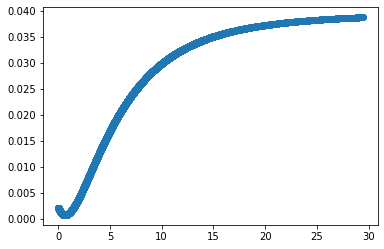

In [42]:
import matplotlib.pyplot as plt
import nelsonsiegelsvensson
# e.g. with 2013, input time and corresponding yield to maturity
TimeVec = dict_data["2013-12-31"]["ttm"]/365
YieldVec = dict_data["2013-12-31"]["ytm"]
beta0   = 0.1 # initial guess
beta1   = 0.1 # initial guess
beta2   = 0.1 # initial guess
beta3   = 0.1 # initial guess
lambda0 = 1 # initial guess
lambda1 = 1 # initial guess

date = example_dates[1]
max_ttm = int(max(dict_data[date]['ttm']))
# date needed for predict
TimeResultVec = np.arange(1,1+max_ttm)/365
# TimeResultVec = dict_data["2013-12-31"]["ttm"]/365 # Maturities for yields that we are interested in

## Implementation
OptiParam = nelsonsiegelsvensson.NSSMinimize(beta0, beta1, beta2, beta3, lambda0, lambda1, TimeVec, YieldVec) # The Nelder-Mead simplex algorithem is used to find the parameters that result in a curve with the minimum residuals compared to the market data.

# Print the yield curve with optimal parameter to compare with the data provided
y_solved_nss = nelsonsiegelsvensson.NelsonSiegelSvansson(TimeResultVec, OptiParam[0], OptiParam[1], OptiParam[2], OptiParam[3], OptiParam[4], OptiParam[5])

g_solved_nss = nelsonsiegelsvensson.convert_y_to_g(y_solved_nss, TimeResultVec)
# plt.scatter(TimeResultVec, g_x)
plt.scatter(TimeResultVec, y_solved_nss)
plt.show()

# Spline

In [43]:
import pandas as pd
spline_data = dict_data["2013-12-31"].copy()
spline_data_yt = pd.DataFrame((spline_data["ttm"], spline_data["ytm"]))
spline_data_yt = spline_data_yt.T
spline_data_yt = spline_data_yt.sort_values(by=0)

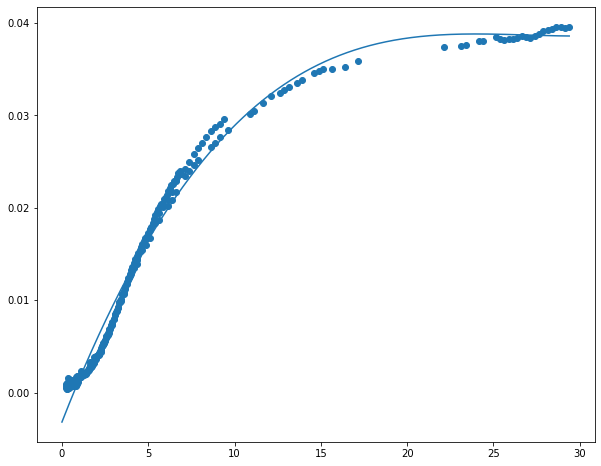

In [44]:
from scipy.interpolate import splev, splrep
from scipy import interpolate
x_spline = (spline_data_yt[0]/365).to_numpy()
y_spline = spline_data_yt[1].to_numpy()

# use bc_type = 'natural' adds the constraints as we described above
f = splrep(x_spline, y_spline, s=2)
x_spline_date = TimeResultVec
y_solved_spline = splev(x_spline_date, f, der=0)
plt.figure(figsize = (10,8))
plt.plot(x_spline_date, y_solved_spline)
plt.scatter(x_spline, y_spline)

g_solved_spline = nelsonsiegelsvensson.convert_y_to_g(y_solved_spline, x_spline_date)
# plt.plot(x_spline_date, g_x_spline)

# Plot fitted curves

The code block below plots fitted discount curve and yield curve up to the maximum time-to-maturity $N'$ in the data. 

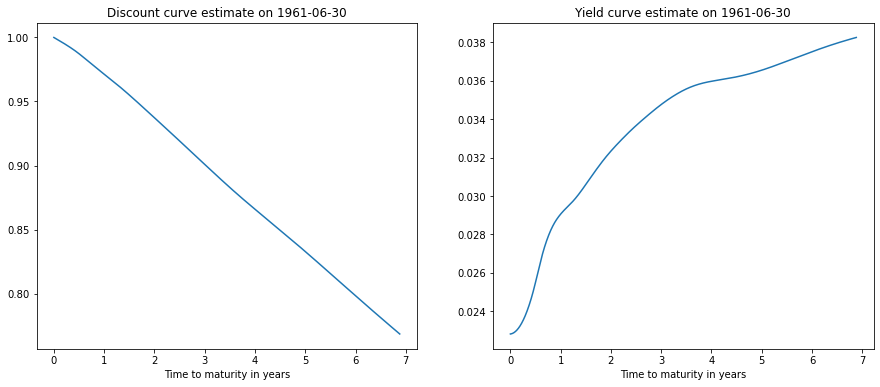

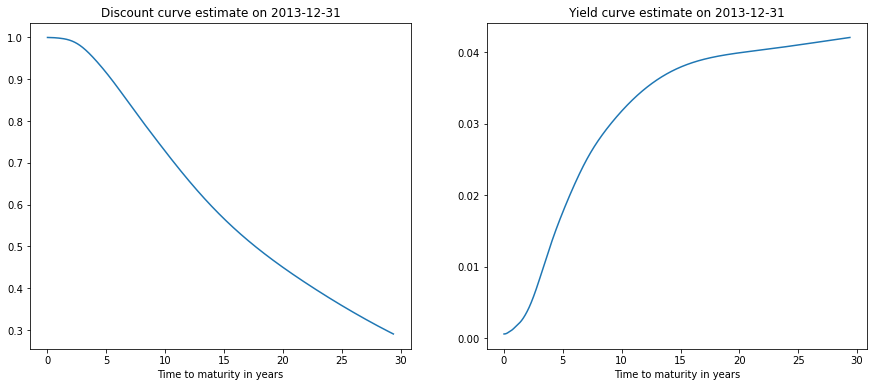

In [13]:
### plot fitted curves up to N'

for date in example_dates:
    fig=plt.figure(figsize=(15,6))
    ax_1,ax_2=fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
    
    max_ttm = int(max(dict_data[date]['ttm']))
    
    ax_1.plot(np.arange(1,1+max_ttm)/365, dict_fit[date]['g_solved'][:max_ttm])
    
    ax_2.plot(np.arange(1,1+max_ttm)/365, dict_fit[date]['y_solved'][:max_ttm])
    # ax_2.scatter(ttm/365, dict_data[example_dates[1]]['ytm'])
    
    ax_1.set_title('Discount curve estimate on {}'.format(date))
    ax_2.set_title('Yield curve estimate on {}'.format(date))
    
    for ax in [ax_1, ax_2]:
        ax.set_xlabel('Time to maturity in years');

# Plot with NSS for fitted curves

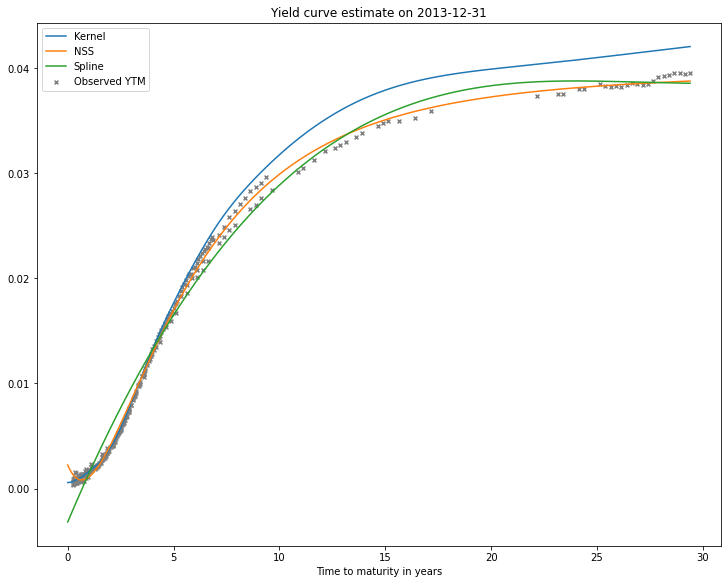

In [8]:
### plot yield curve

date = example_dates[1]
# to add traces
fig, ax = plt.subplots(figsize=(10, 8), layout='constrained')

max_ttm = int(max(dict_data[date]['ttm']))

ax.plot(np.arange(1,1+max_ttm)/365, dict_fit[date]['y_solved'][:max_ttm], label='Kernel')
ax.plot(np.arange(1,1+max_ttm)/365, y_solved_nss, label='NSS')
ax.plot(x_spline_date, y_solved_spline, label = 'Spline')
ax.scatter(dict_data[date]["ttm"]/365, dict_data[date]['ytm'], color="gray", marker='x',alpha=1, s=15, label='Observed YTM')
# ax.scatter(ttm/365, ytm_fitted, marker='x', label='Fitted YTM Kernel')

ax.legend()
ax.set_title('Yield curve estimate on {}'.format(date))
    
ax.set_xlabel('Time to maturity in years');

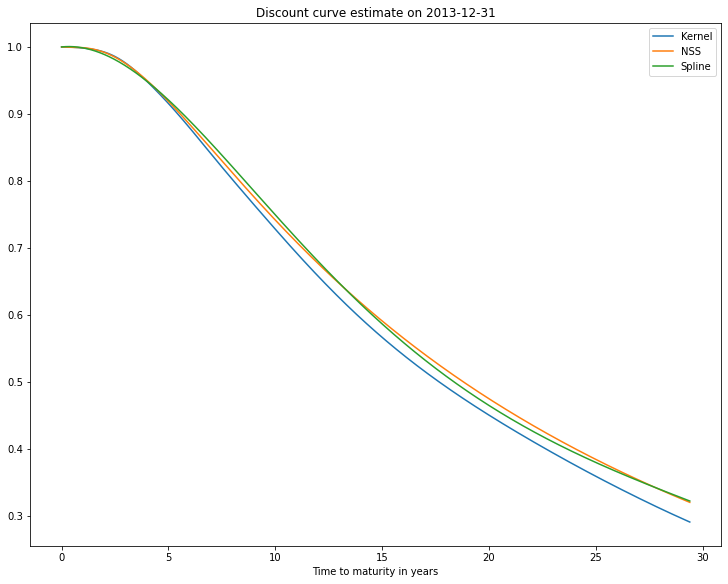

In [9]:
## plot discount curve
date = example_dates[1]

fig, ax = plt.subplots(figsize=(10, 8), layout='constrained')

max_ttm = int(max(dict_data[date]['ttm']))

ttm = np.zeros(M) # time to maturity in days

ax.plot(np.arange(1,1+max_ttm)/365, dict_fit[date]['g_solved'][:max_ttm], label='Kernel')
ax.plot(np.arange(1,1+max_ttm)/365, g_solved_nss, label='NSS')
ax.plot(x_spline_date,g_solved_spline, label = "Spline")

ax.legend()
ax.set_title('Discount curve estimate on {}'.format(date))
    
ax.set_xlabel('Time to maturity in years');

# Plot fitted yield-to-maturity (YTM)

The code block below plots YTM implied by observed prices and _model-implied prices_.

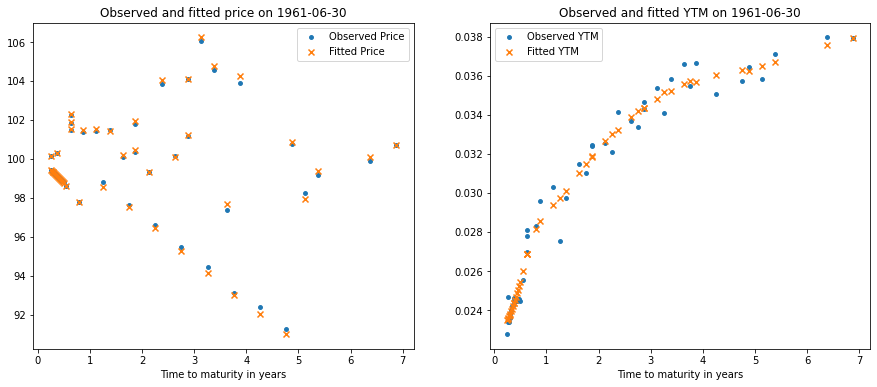

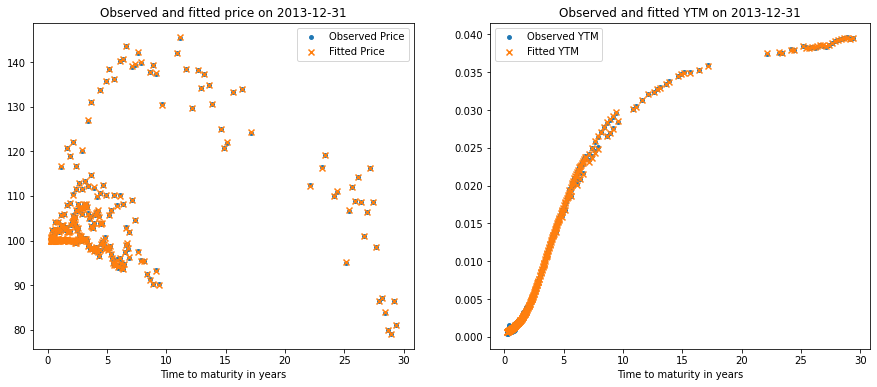

In [16]:
for date in example_dates:
    
    # load price vector and cashflow matrix
    C=dict_data[date]['C']
    M=C.shape[0]
  
    # calculate implied prices by fitted discount curve
    B_fitted=C@dict_fit[date]['g_solved'][:C.shape[1]]

    # get YTM and duration
    ytm_fitted = np.zeros(M) # YTM and duration
    ttm = np.zeros(M) # time to maturity in days
    
    for i in range(M):
        time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
        ytm_fitted[i], _ = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1],
                                                         time_to_cashflow_inday,
                                                         B_fitted[i])
        ttm[i] = max(time_to_cashflow_inday)
        
    
    # plot
    fig=plt.figure(figsize=(15,6))
    ax_1,ax_2=fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
    

    ax_1.scatter(ttm/365, dict_data[date]['B'], marker='o', s=15, label='Observed Price');
    ax_1.scatter(ttm/365, B_fitted, marker='x', label='Fitted Price');
    
    ax_2.scatter(ttm/365, dict_data[date]['ytm'], marker='o', s=15, label='Observed YTM');
    ax_2.scatter(ttm/365, ytm_fitted, marker='x', label='Fitted YTM');
  

    ax_1.set_title('Observed and fitted price on {}'.format(date));
    ax_2.set_title('Observed and fitted YTM on {}'.format(date));
    
    for ax in [ax_1, ax_2]:
        ax.legend();
        ax.set_xlabel('Time to maturity in years');
    

# Predicted With Kernel, NSS and Spline

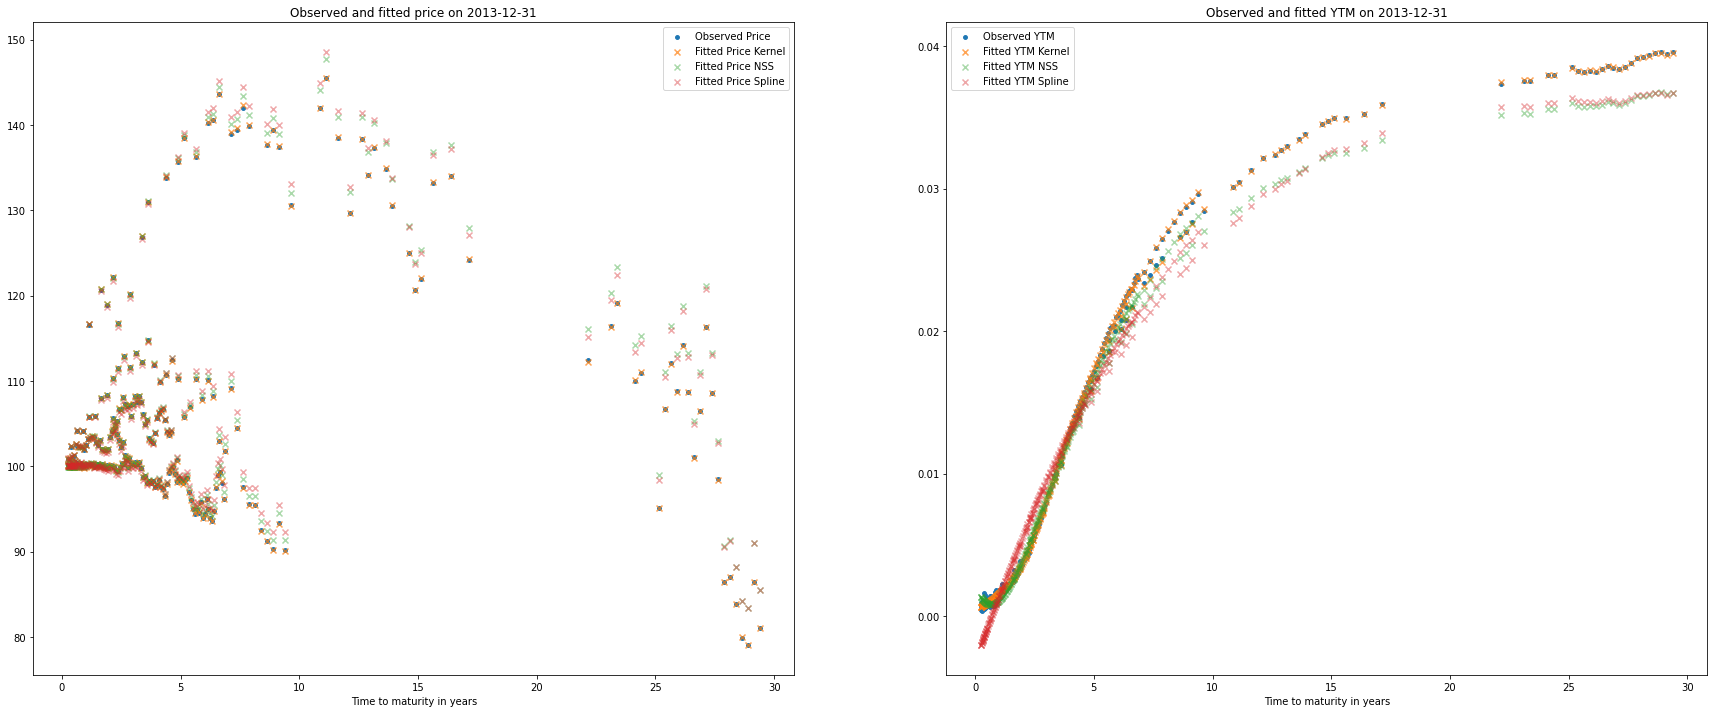

In [45]:
date = example_dates[1]
# load price vector and cashflow matrix
C=dict_data[date]['C']
M=C.shape[0]
  
# calculate implied prices by fitted discount curve
B_fitted=C@dict_fit[date]['g_solved'][:C.shape[1]]
B_fitted_nss = C@g_solved_nss[:C.shape[1]]
B_fitted_spline = C@g_solved_spline[:C.shape[1]]
# get YTM and duration
ytm_fitted = np.zeros(M) # YTM and duration
ttm = np.zeros(M) # time to maturity in days

for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    ytm_fitted[i], _ = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1],
                                                        time_to_cashflow_inday,
                                                        B_fitted[i])
    ttm[i] = max(time_to_cashflow_inday)
    
ytm_fitted_nss = np.zeros(M) # YTM and duration
ttm_nss = np.zeros(M) # time to maturity in days
for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    ytm_fitted_nss[i], _ = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1],
                                                        time_to_cashflow_inday,
                                                        B_fitted_nss[i])
    ttm_nss[i] = max(time_to_cashflow_inday)

ytm_fitted_spline = np.zeros(M) # YTM and duration
ttm_spline = np.zeros(M) # time to maturity in days

for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    ytm_fitted_spline[i], _ = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1],
                                                        time_to_cashflow_inday,
                                                        B_fitted_spline[i])
    ttm_spline[i] = max(time_to_cashflow_inday)
  
  
# plot
fig=plt.figure(figsize=(30,12))
ax_1,ax_2=fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)


ax_1.scatter(ttm/365, dict_data[date]['B'], marker='o', s=15, label='Observed Price');
ax_1.scatter(ttm/365, B_fitted, marker='x',alpha=0.7,  label='Fitted Price Kernel');
ax_1.scatter(ttm/365, B_fitted_nss, marker='x', alpha=0.4, label='Fitted Price NSS')
ax_1.scatter(ttm/365, B_fitted_spline, marker='x', alpha=0.4, label='Fitted Price Spline')

ax_2.scatter(ttm/365, dict_data[date]['ytm'], marker='o', s=15, label='Observed YTM');
ax_2.scatter(ttm/365, ytm_fitted, marker='x',alpha=0.7, label='Fitted YTM Kernel');
ax_2.scatter(ttm/365, ytm_fitted_nss, marker='x',alpha=0.4, label='Fitted YTM NSS');
ax_2.scatter(ttm/365, ytm_fitted_spline, marker='x',alpha=0.4, label='Fitted YTM Spline')

ax_1.set_title('Observed and fitted price on {}'.format(date));
ax_2.set_title('Observed and fitted YTM on {}'.format(date));

for ax in [ax_1, ax_2]:
    ax.legend();
    ax.set_xlabel('Time to maturity in years');


# Add noise

In [18]:
import copy
a = {"a" : [1,2,3], "c" : 2}
b = copy.deepcopy(a)
b["a"][1] = 6
a

{'a': [1, 2, 3], 'c': 2}

In [19]:
import copy
noise_data = copy.deepcopy(dict_data["2013-12-31"])

In [22]:
noise_data["ttm"][noise_data["ttm"] == 6255]
noise_data["B"][noise_data["ttm"] == 6255]

array([136.56328125])

In [21]:
# noise in about 17 yrs
noise_data["ttm"][noise_data["ttm"] == 6255]
# # make price increase 10%
noise_data["B"][noise_data["ttm"] == 6255] = noise_data["B"][noise_data["ttm"] == 6255]*1.1
noise_data["B"][noise_data["ttm"] == 6255]

array([136.56328125])

In [38]:
# # choose around 9 yrs
# noise_data["ttm"][noise_data["ttm"] == 3333]
# # make price increase 10%
# noise_data["B"][noise_data["ttm"] == 3333] = noise_data["B"][noise_data["ttm"] == 3333]*1.1
# noise_data["B"][noise_data["ttm"] == 3333]

array([151.12109375, 102.70390625])

In [24]:
# choose around 9 yrs
# make price increase 10%
filt = (noise_data["ttm"] >= 3000) * (noise_data["ttm"] <= 3500)

noise_data["B"][filt]

array([137.6953125 , 139.40642265, 137.3828125 ,  92.51143819,
        91.2890625 ,  90.31586671,  93.3671875 ,  90.18331319])

In [23]:
# check if deepcopy works
dict_data["2013-12-31"]["B"][noise_data["ttm"] == 6255]
dict_data["2013-12-31"]["B"][noise_data["ttm"] >= 3000]
dict_data["2013-12-31"]["B"][filt]

array([137.6953125 , 139.40642265, 137.3828125 ,  92.51143819,
        91.2890625 ,  90.31586671,  93.3671875 ,  90.18331319])

In [11]:
noise_data["B"][filt] = noise_data["B"][filt]*1.1
noise_data["B"][filt]

array([151.46484375, 153.34706492, 151.12109375, 101.76258201,
       100.41796875,  99.34745338, 102.70390625,  99.20164451])

## fit NSS and spline with noise

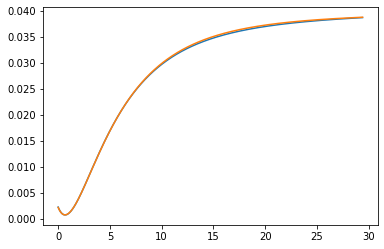

In [25]:
date = example_dates[1]
# load price vector and cashflow matrix
B=noise_data["B"]
C=noise_data["C"]
M=B.shape[0]
noise_data_full = {}
# get YTM and duration
_ytm, _dur=np.zeros(M), np.zeros(M) # YTM and duration
_ttm = np.zeros(M) # time to maturity in days
for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    _ytm[i], _dur[i] = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1], time_to_cashflow_inday, B[i])
    _ttm[i] = max(time_to_cashflow_inday)

# get inverse of weights for fitting
# weights w is computed as w=1/inv_w
_inv_w=(_dur*B)**2*M

noise_data_full={'B':B, 'C':C, 'ytm':_ytm, 'dur':_dur, 'ttm':_ttm, 'inv_w':_inv_w}
#######################################################################################
noise_fit={}
    
noise_fit=kr_model.KR(C=noise_data_full['C'], # cashflow matrix
                        B=noise_data_full['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=noise_data_full['inv_w'], # inverse of the weighting vector
                        K=K # kernel matrix
                    )


# e.g. with 2013, input time and corresponding yield to maturity
TimeVec = noise_data_full["ttm"]/365
YieldVec = noise_data_full["ytm"]
beta0   = 0.1 # initial guess
beta1   = 0.1 # initial guess
beta2   = 0.1 # initial guess
beta3   = 0.1 # initial guess
lambda0 = 1 # initial guess
lambda1 = 1 # initial guess

date = example_dates[1]
max_ttm = int(max(noise_data_full["ttm"]))
# date needed for predict
TimeResultVec = np.arange(1,1+max_ttm)/365
# TimeResultVec = dict_data["2013-12-31"]["ttm"]/365 # Maturities for yields that we are interested in

## Implementation
OptiParam = nelsonsiegelsvensson.NSSMinimize(beta0, beta1, beta2, beta3, lambda0, lambda1, TimeVec, YieldVec) # The Nelder-Mead simplex algorithem is used to find the parameters that result in a curve with the minimum residuals compared to the market data.

# Print the yield curve with optimal parameter to compare with the data provided
y_noise_nss = nelsonsiegelsvensson.NelsonSiegelSvansson(TimeResultVec, OptiParam[0], OptiParam[1], OptiParam[2], OptiParam[3], OptiParam[4], OptiParam[5])

g_noise_nss = nelsonsiegelsvensson.convert_y_to_g(y_noise_nss, TimeResultVec)
plt.plot(TimeResultVec, y_noise_nss)
plt.plot(TimeResultVec, y_solved_nss)
plt.show()

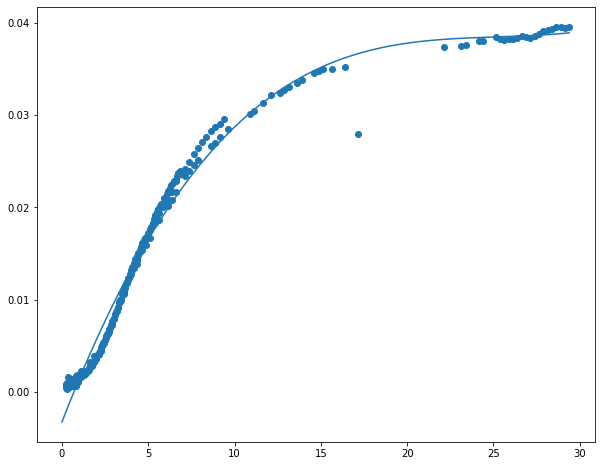

In [26]:
import pandas as pd
spline_data_noise = noise_data_full.copy()
spline_data_yt_noise = pd.DataFrame((spline_data_noise["ttm"], spline_data_noise["ytm"]))
spline_data_yt_noise = spline_data_yt_noise.T
spline_data_yt_noise = spline_data_yt_noise.sort_values(by=0)

from scipy.interpolate import splev, splrep
from scipy import interpolate
x_spline_noise = (spline_data_yt_noise[0]/365).to_numpy()
y_spline_noise = spline_data_yt_noise[1].to_numpy()

# use bc_type = 'natural' adds the constraints as we described above
f = splrep(x_spline_noise, y_spline_noise, s=256)
x_splinefit_noise = TimeResultVec
y_splinefit_noise = splev(x_splinefit_noise, f, der=0)
plt.figure(figsize = (10,8))
plt.plot(x_splinefit_noise, y_splinefit_noise)
plt.scatter(x_spline_noise, y_spline_noise)

g_spline_noise = nelsonsiegelsvensson.convert_y_to_g(y_splinefit_noise, x_splinefit_noise)
# plt.plot(x_new_noise, g_x_spline_noise)

## Plot results

In [27]:
date = example_dates[1]
# load price vector and cashflow matrix
C=noise_data["C"]
M=C.shape[0]
  
# calculate implied prices by fitted discount curve
B_fitted=C@noise_fit["g_solved"][:C.shape[1]]
B_fitted_nss = C@g_noise_nss[:C.shape[1]]
B_fitted_Spline = C@g_spline_noise[:C.shape[1]]
# get YTM and duration
ytm_fitted_noise = np.zeros(M) # YTM and duration
ttm = np.zeros(M) # time to maturity in days

for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    ytm_fitted_noise[i], _ = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1],
                                                        time_to_cashflow_inday,
                                                        B_fitted[i])
    ttm[i] = max(time_to_cashflow_inday)
    
ytm_fitted_noise_nss = np.zeros(M) # YTM and duration
ttm_nss = np.zeros(M) # time to maturity in days
for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    ytm_fitted_noise_nss[i], _ = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1],
                                                        time_to_cashflow_inday,
                                                        B_fitted_nss[i])
    ttm_nss[i] = max(time_to_cashflow_inday)

ytm_fitted_noise_sp = np.zeros(M) # YTM and duration
ttm_sp = np.zeros(M) # time to maturity in days
for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    ytm_fitted_noise_sp[i], _ = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1],
                                                        time_to_cashflow_inday,
                                                        B_fitted_Spline[i])
    ttm_sp[i] = max(time_to_cashflow_inday)


In [28]:
unique_date = np.unique(ttm, return_index=True)
unique_date_days = unique_date[0]
unique_ytm_kernel = ytm_fitted_noise[unique_date[1]]

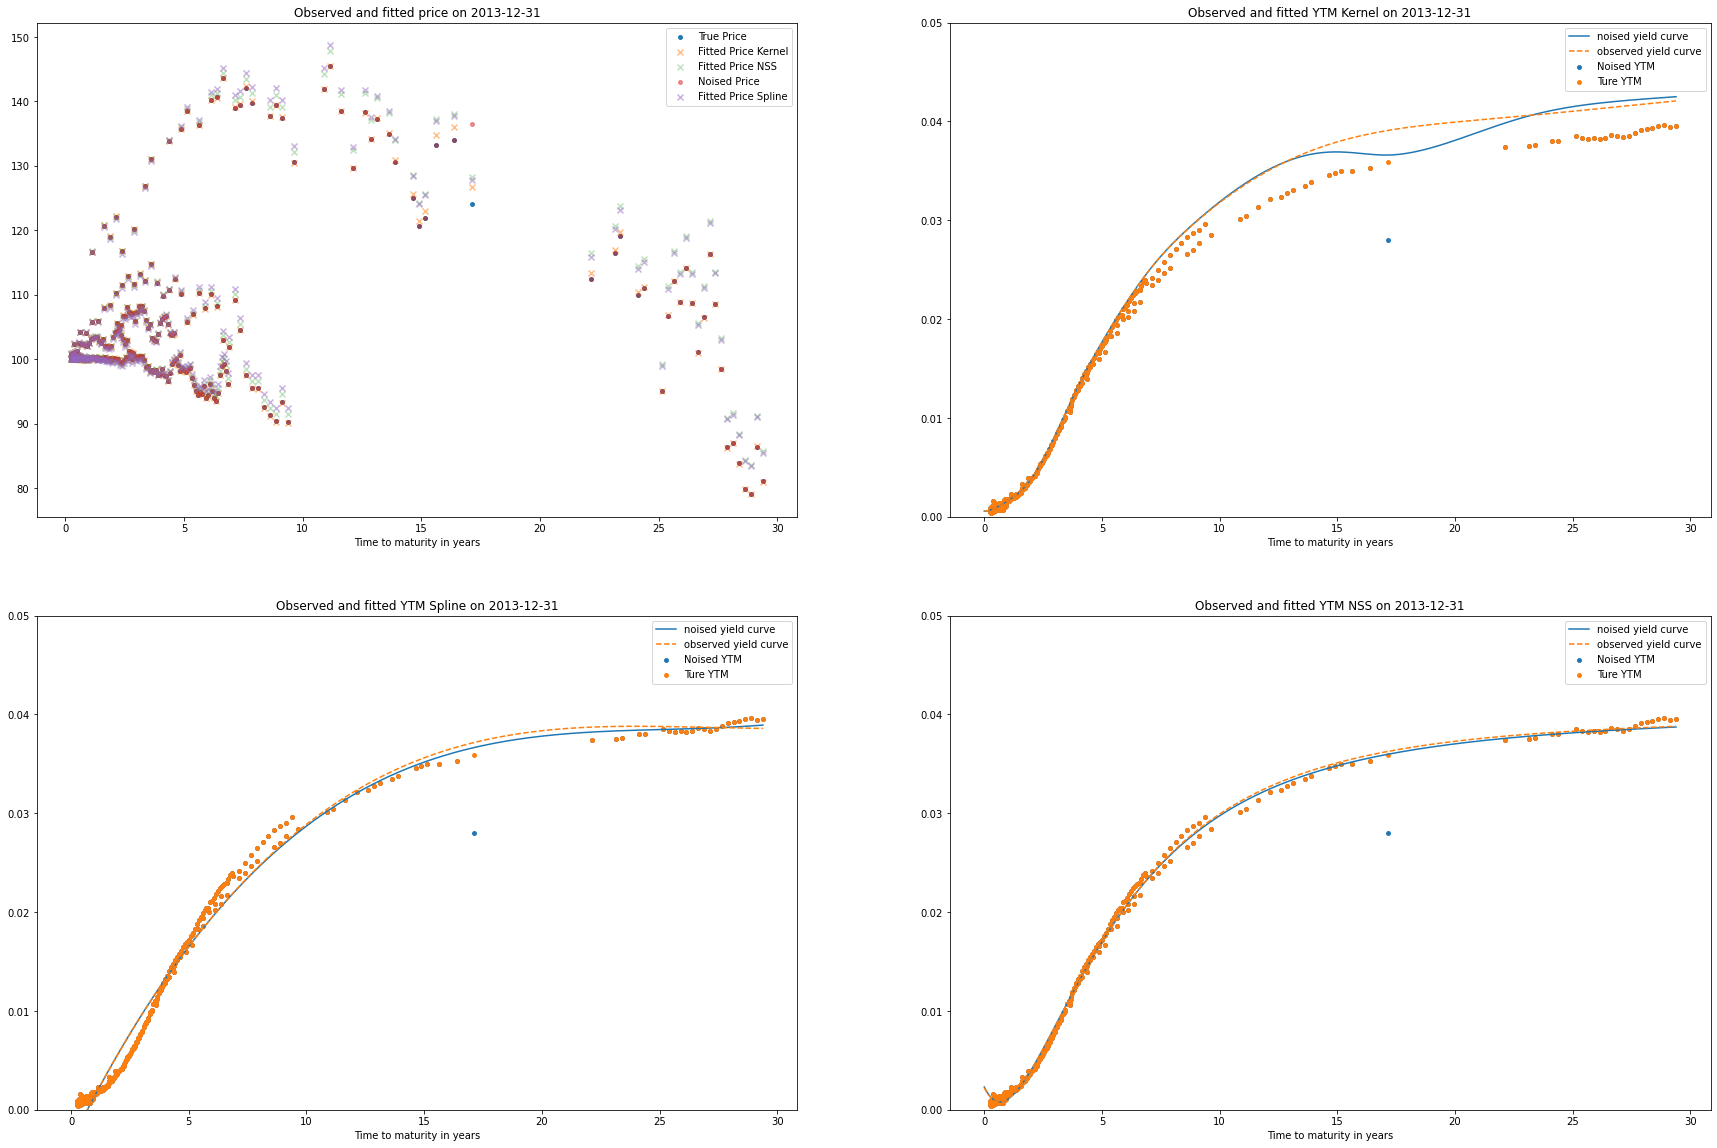

In [29]:
# plot
fig=plt.figure(figsize=(30,20))
ax_1,ax_2, ax_3, ax_4=fig.add_subplot(2, 2, 1), fig.add_subplot(2,2,2), fig.add_subplot(2,2,3), fig.add_subplot(2,2,4)


ax_1.scatter(ttm/365, dict_data[date]['B'], marker='o', s=15, label='True Price');
ax_1.scatter(ttm/365, B_fitted, marker='x',alpha=0.5,  label='Fitted Price Kernel');
ax_1.scatter(ttm/365, B_fitted_nss, marker='x', alpha=0.3, label='Fitted Price NSS');
ax_1.scatter(ttm/365, noise_data_full["B"], marker='o', alpha=0.5, s=15, label='Noised Price');
ax_1.scatter(ttm/365, B_fitted_Spline, marker='x',alpha=0.5, label='Fitted Price Spline')

# ax_2.scatter(ttm/365, ytm_fitted_noise, marker='x',alpha=0.5, label='Fitted YTM Kernel');
ax_2.plot(np.arange(1,1+max_ttm)/365, noise_fit["y_solved"][:max_ttm], label= "noised yield curve")
ax_2.plot(np.arange(1,1+max_ttm)/365, dict_fit["2013-12-31"]["y_solved"][:max_ttm], linestyle='--', label= "observed yield curve")
# ax_2.scatter(ttm/365, ytm_fitted, marker='x',alpha=0.3, label='Fitted YTM true');
ax_2.scatter(ttm/365, noise_data_full["ytm"], marker='o', s=15, label='Noised YTM')
ax_2.scatter(ttm/365, dict_data[date]['ytm'], marker='o', s=15, label='Ture YTM')


# ax_3.scatter(ttm/365, ytm_fitted_noise_nss, marker='x',alpha=0.5, label='Fitted YTM NSS');
# ax_3.scatter(ttm/365, ytm_fitted_nss, marker='x',alpha=0.3, label='Fitted YTM true');
ax_3.plot(np.arange(1,1+max_ttm)/365, y_splinefit_noise[:max_ttm], label= "noised yield curve");
ax_3.plot(np.arange(1,1+max_ttm)/365, y_solved_spline[:max_ttm], linestyle='--', label= "observed yield curve")
ax_3.scatter(ttm/365, noise_data_full["ytm"], marker='o', s=15, label='Noised YTM')
ax_3.scatter(ttm/365, dict_data[date]['ytm'], marker='o', s=15, label='Ture YTM')


# ax_4.scatter(ttm/365, ytm_fitted_noise_sp, marker='x',alpha=0.5, label='Fitted YTM Spline');
ax_4.plot(x_spline_date, y_noise_nss, label= "noised yield curve")
ax_4.plot(x_spline_date, y_solved_nss, linestyle='--', label= "observed yield curve")
# ax_4.scatter(ttm/365, ytm_fitted_spline, marker='x',alpha=0.3, label='Fitted YTM true');
ax_4.scatter(ttm/365, noise_data_full["ytm"], marker='o', s=15, label='Noised YTM')
ax_4.scatter(ttm/365, dict_data[date]['ytm'], marker='o', s=15, label='Ture YTM')

ax_1.set_title('Observed and fitted price on {}'.format(date));
ax_2.set_title('Observed and fitted YTM Kernel on {}'.format(date));
ax_4.set_title('Observed and fitted YTM NSS on {}'.format(date));
ax_3.set_title('Observed and fitted YTM Spline on {}'.format(date))

for ax in [ax_1, ax_2, ax_3, ax_4]:
    ax.legend();
    ax.set_xlabel('Time to maturity in years');

for ax in [ax_2, ax_3, ax_4]:
    ax.set_ylim([0,0.05])

Text(0.5, 1.0, 'weighted RMSE for noised fitted price')

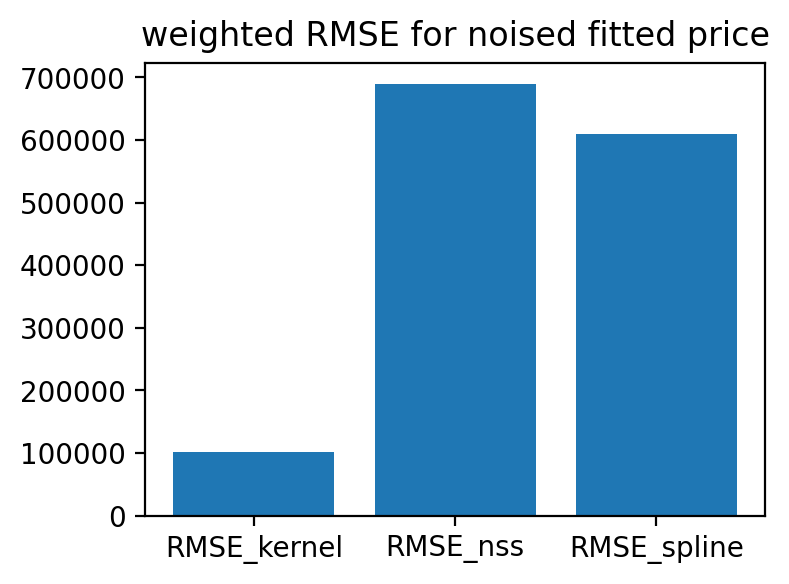

In [30]:
RMSE_kernel = (inv_w.T@(dict_data[date]['B'] - B_fitted)**2)**(1/2)
RMSE_nss = (inv_w.T@(dict_data[date]['B'] - B_fitted_nss)**2)**(1/2)
RMSE_spline = (inv_w.T@(dict_data[date]['B'] - B_fitted_spline)**2)**(1/2)
plt.figure(figsize=(4,3),dpi=200)
plt.bar(["RMSE_kernel", "RMSE_nss", "RMSE_spline"],[RMSE_kernel,RMSE_nss,RMSE_spline])
plt.title("weighted RMSE for noised fitted price")

# confidence band

In [31]:
import Gaussian_confidence
var, std, lower, upper = Gaussian_confidence.KR_gaussian(dict_data[date]["C"],
                                           dict_data[date]["B"],
                                           ridge=ridge, 
                                           inv_w=dict_data[date]['inv_w'], 
                                           K=K  )

d:\Master\[Research Module]\Robust-Machine-Learning-for-Yield-Curve-Estimation\code&data\src\Gaussian_confidence.py:55: RuntimeWarning: invalid value encountered in sqrt
  std_price = np.sqrt(var_price)


In [32]:
import Gaussian_confidence
var2, std2, lower2, upper2 = Gaussian_confidence.KR_gaussian2(dict_data[date]["C"],
                                           dict_data[date]["B"],
                                           ridge=ridge, 
                                           inv_w=dict_data[date]['inv_w'], 
                                           K=K  )

d:\Master\[Research Module]\Robust-Machine-Learning-for-Yield-Curve-Estimation\code&data\src\Gaussian_confidence.py:115: RuntimeWarning: invalid value encountered in sqrt
  std_price = np.sqrt(var_price)


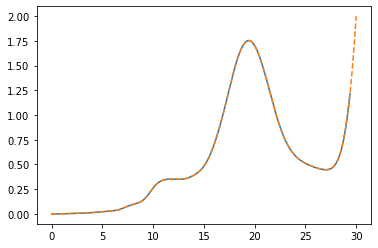

In [33]:
plt.plot(np.arange(1,1+len(var2))/365, var2)
plt.plot(np.arange(1,1+len(var))/365, var, "--")

Text(0.5, 1.0, 'Distribution of time to maturity')

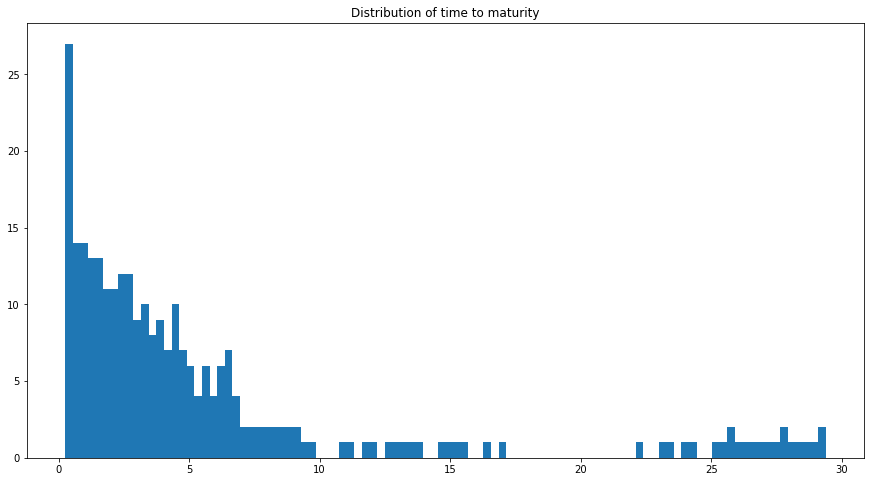

In [34]:
plt.figure(figsize=(15,8))
plt.hist(dict_data[date]["ttm"]/365, bins=100)
plt.title("Distribution of time to maturity")

Text(0.5, 0, 'Time to maturity in years')

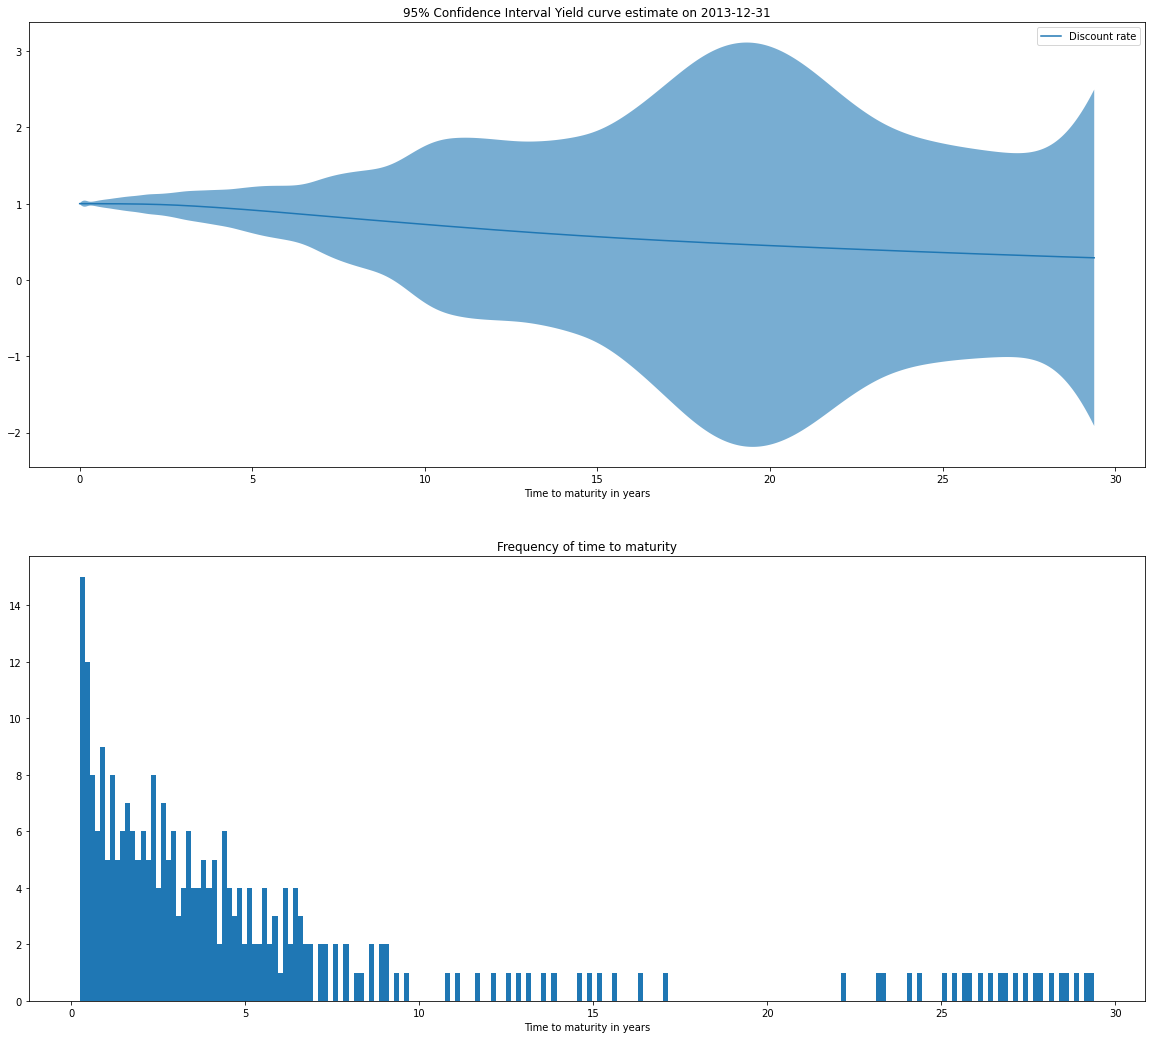

In [35]:
fig = plt.figure(figsize=(20, 18))
ax, ax_1 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
max_ttm = int(max(dict_data[date]['ttm']))

ax.plot(np.arange(1,1+max_ttm)/365, dict_fit[date]['g_solved'][:max_ttm], label='Discount rate')
ax.fill_between(np.arange(1,1+max_ttm)/365,
                dict_fit[date]['g_solved'][:max_ttm] - 2*std[:max_ttm],
                 dict_fit[date]['g_solved'][:max_ttm] + 2*std[:max_ttm],alpha = 0.6)
ax_1.hist(dict_data[date]["ttm"]/365, bins=200)

ax.legend()
ax.set_title('95% Confidence Interval Yield curve estimate on {}'.format(date))
ax_1.set_title("Frequency of time to maturity")
ax.set_xlabel('Time to maturity in years');
ax_1.set_xlabel('Time to maturity in years')

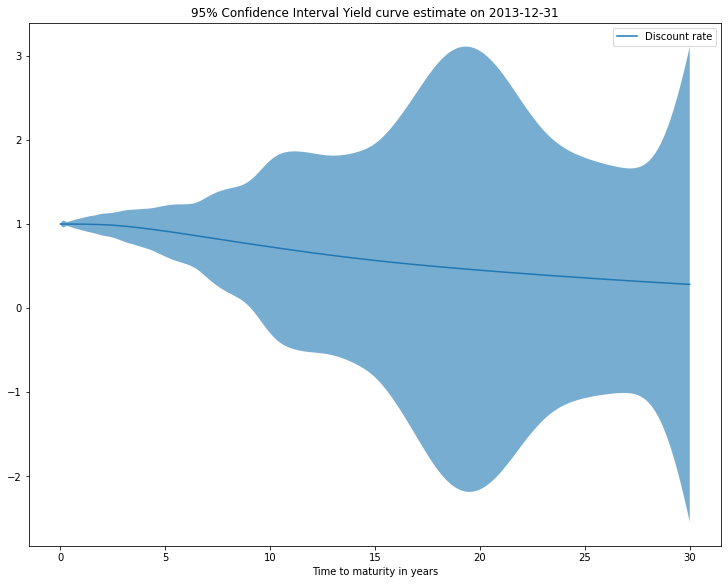

In [36]:
fig, ax = plt.subplots(figsize=(10, 8), layout='constrained')

day_to_plot = len(std)

ax.plot(np.arange(1,1+day_to_plot)/365, dict_fit[date]['g_solved'][:day_to_plot], label='Discount rate')
ax.fill_between(np.arange(1,1+day_to_plot)/365,
                dict_fit[date]['g_solved'][:day_to_plot] - 2*std[:day_to_plot],
                 dict_fit[date]['g_solved'][:day_to_plot] + 2*std[:day_to_plot],alpha = 0.6)

# ax.set_ylim(0,1.2)
ax.legend()
ax.set_title('95% Confidence Interval Yield curve estimate on {}'.format(date))
    
ax.set_xlabel('Time to maturity in years');

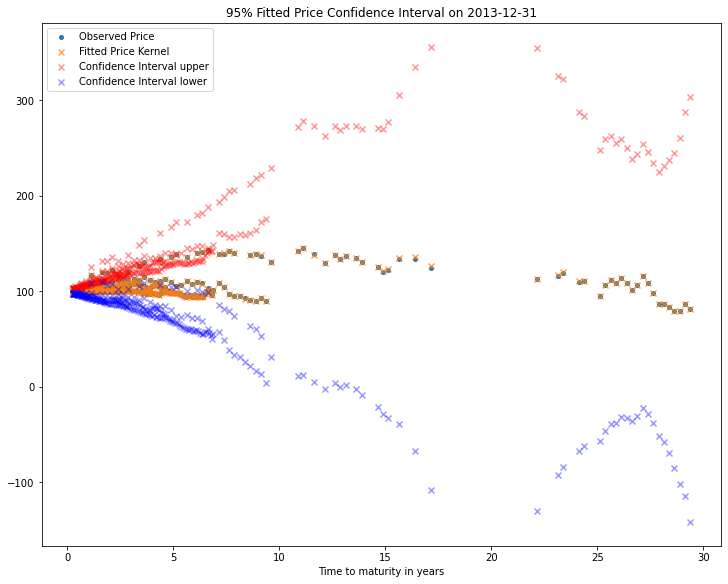

In [37]:
fig, ax_1 = plt.subplots(figsize=(10, 8), layout='constrained')


ax_1.scatter(ttm/365, dict_data[date]['B'], marker='o', s=15, label='Observed Price');
ax_1.scatter(ttm/365, B_fitted, marker='x',alpha=0.7,  label='Fitted Price Kernel');
ax_1.scatter(ttm/365, upper, marker='x', alpha=0.4,color = "red", label='Confidence Interval upper')
ax_1.scatter(ttm/365, lower, marker='x', alpha=0.4,color = "blue",  label='Confidence Interval lower')

ax_1.legend()

ax_1.set_title('95% Fitted Price Confidence Interval on {}'.format(date))
    
ax_1.set_xlabel('Time to maturity in years');

# exp

## change lambda

In [46]:
### settings
# kernel hyper-parameters
alpha=0.05
delta=0.00
# max time to maturity in days
N2=40*365

K_40y = kr_model.generate_kernel_matrix(alpha, delta, N2, N2)

ridge=1 #lambda

dict_fit_exp={}
dict_fit_exp = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [10]:
ridge=5 #lambda

dict_fit_exp_5={}
dict_fit_exp_5 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [11]:
ridge=10 #lambda

dict_fit_exp_10={}
dict_fit_exp_10 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [12]:
ridge=50 #lambda

dict_fit_exp_50={}
dict_fit_exp_50 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [13]:
ridge=0.5 #lambda

dict_fit_exp_05={}
dict_fit_exp_05 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [14]:
ridge=0.1 #lambda

dict_fit_exp_01={}
dict_fit_exp_01 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [15]:
ridge=0.01 #lambda

dict_fit_exp_001={}
dict_fit_exp_001 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

## plot

(0.0, 0.05)

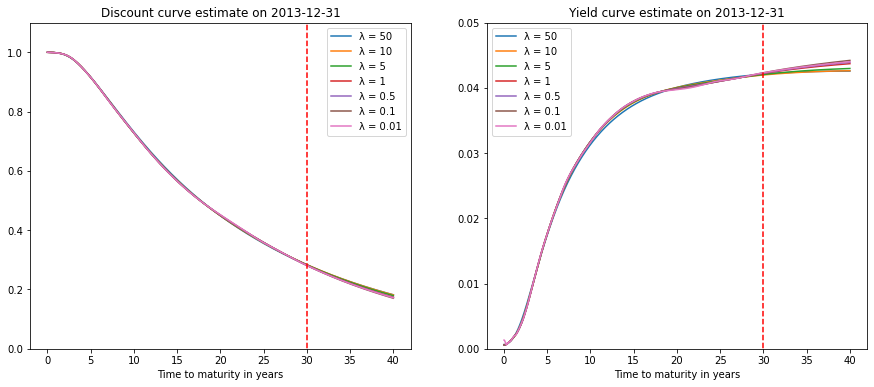

In [16]:

fig = plt.figure(figsize=(15, 6))
ax, ax_1 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)

ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_50['g_solved'][:N2], label='\u03BB = 50')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_10['g_solved'][:N2], label='\u03BB = 10')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_5['g_solved'][:N2], label='\u03BB = 5')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp['g_solved'][:N2], label='\u03BB = 1')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_05['g_solved'][:N2], label='\u03BB = 0.5')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_01['g_solved'][:N2], label='\u03BB = 0.1')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_001['g_solved'][:N2], label='\u03BB = 0.01')
ax.vlines(30, ymin=-0.5,ymax=1.5, color = "red", linestyles="dashed")

ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_50['y_solved'][:N2], label='\u03BB = 50')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_10['y_solved'][:N2], label='\u03BB = 10')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_5['y_solved'][:N2], label='\u03BB = 5')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp['y_solved'][:N2], label='\u03BB = 1')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_05['y_solved'][:N2], label='\u03BB = 0.5')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_01['y_solved'][:N2], label='\u03BB = 0.1')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_001['y_solved'][:N2], label='\u03BB = 0.01')
ax_1.vlines(30, ymin=-0.5,ymax=1.5,  color = "red", linestyles="dashed")

ax.legend()
ax_1.legend()
ax.set_title('Discount curve estimate on {}'.format(date))
ax_1.set_title('Yield curve estimate on {}'.format(date))
ax.set_xlabel('Time to maturity in years')
ax_1.set_xlabel('Time to maturity in years')
ax.set_ylim(0,1.1)
ax_1.set_ylim(0,0.05)

## change alpha

In [17]:
### settings
# kernel hyper-parameters
alpha=0.05
delta=0.00
# max time to maturity in days
N2=40*365

K_40y = kr_model.generate_kernel_matrix(alpha, delta, N2, N2)

ridge=1 #lambda

dict_fit_exp={}
dict_fit_exp = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [18]:
# kernel hyper-parameters
alpha=0.1
delta=0.00
# max time to maturity in days
N2=40*365

K_40y = kr_model.generate_kernel_matrix(alpha, delta, N2, N2)

ridge=1 #lambda

dict_fit_exp_a01={}
dict_fit_exp_a01 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [19]:
# kernel hyper-parameters
alpha=0.01
delta=0.00
# max time to maturity in days
N2=40*365

K_40y = kr_model.generate_kernel_matrix(alpha, delta, N2, N2)

ridge=1 #lambda

dict_fit_exp_a001={}
dict_fit_exp_a001 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [20]:
# kernel hyper-parameters
alpha=0.03
delta=0.00
# max time to maturity in days
N2=40*365

K_40y = kr_model.generate_kernel_matrix(alpha, delta, N2, N2)

ridge=1 #lambda

dict_fit_exp_a003={}
dict_fit_exp_a003 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

In [21]:
# kernel hyper-parameters
alpha=0.07
delta=0.00
# max time to maturity in days
N2=40*365

K_40y = kr_model.generate_kernel_matrix(alpha, delta, N2, N2)

ridge=1 #lambda

dict_fit_exp_a007={}
dict_fit_exp_a007 = kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                        B=dict_data[date]['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                        K=K_40y # kernel matrix
                    )

(0.0, 0.05)

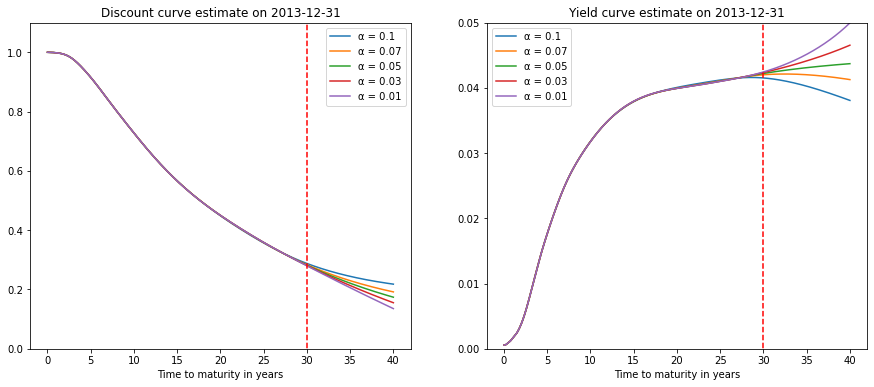

In [22]:

fig = plt.figure(figsize=(15, 6))
ax, ax_1 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)

ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_a01['g_solved'][:N2], label='\u03B1 = 0.1')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_a007['g_solved'][:N2], label='\u03B1 = 0.07')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp['g_solved'][:N2], label='\u03B1 = 0.05')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_a003['g_solved'][:N2], label='\u03B1 = 0.03')
ax.plot(np.arange(1,1+N2)/365, dict_fit_exp_a001['g_solved'][:N2], label='\u03B1 = 0.01')
ax.vlines(30, ymin=-0.5,ymax=1.5, color = "red", linestyles="dashed")

ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_a01['y_solved'][:N2], label='\u03B1 = 0.1')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_a007['y_solved'][:N2], label='\u03B1 = 0.07')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp['y_solved'][:N2], label='\u03B1 = 0.05')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_a003['y_solved'][:N2], label='\u03B1 = 0.03')
ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp_a001['y_solved'][:N2], label='\u03B1 = 0.01')
ax_1.vlines(30, ymin=-0.5,ymax=1.5,  color = "red", linestyles="dashed")

ax.legend()
ax_1.legend()
ax.set_title('Discount curve estimate on {}'.format(date))
ax_1.set_title('Yield curve estimate on {}'.format(date))
ax.set_xlabel('Time to maturity in years')
ax_1.set_xlabel('Time to maturity in years')
ax.set_ylim(0,1.1)
ax_1.set_ylim(0,0.05)

## with spline and nss

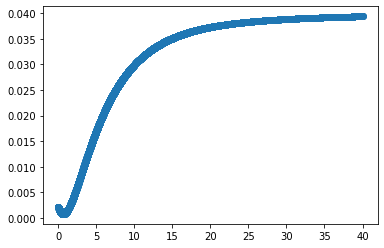

In [50]:
import matplotlib.pyplot as plt
import nelsonsiegelsvensson
# e.g. with 2013, input time and corresponding yield to maturity
TimeVec = dict_data["2013-12-31"]["ttm"]/365
YieldVec = dict_data["2013-12-31"]["ytm"]
beta0   = 0.1 # initial guess
beta1   = 0.1 # initial guess
beta2   = 0.1 # initial guess
beta3   = 0.1 # initial guess
lambda0 = 1 # initial guess
lambda1 = 1 # initial guess

date = example_dates[1]
max_ttm = int(max(dict_data[date]['ttm']))
# date needed for predict
TimeResultVec = np.arange(1,1 + N2)/365
# TimeResultVec = dict_data["2013-12-31"]["ttm"]/365 # Maturities for yields that we are interested in

## Implementation
OptiParam = nelsonsiegelsvensson.NSSMinimize(beta0, beta1, beta2, beta3, lambda0, lambda1, TimeVec, YieldVec) # The Nelder-Mead simplex algorithem is used to find the parameters that result in a curve with the minimum residuals compared to the market data.

# Print the yield curve with optimal parameter to compare with the data provided
y_solved_nss_exp = nelsonsiegelsvensson.NelsonSiegelSvansson(TimeResultVec, OptiParam[0], OptiParam[1], OptiParam[2], OptiParam[3], OptiParam[4], OptiParam[5])

g_solved_nss_exp = nelsonsiegelsvensson.convert_y_to_g(y_solved_nss_exp, TimeResultVec)
# plt.scatter(TimeResultVec, g_x)
plt.scatter(TimeResultVec, y_solved_nss_exp)
plt.show()

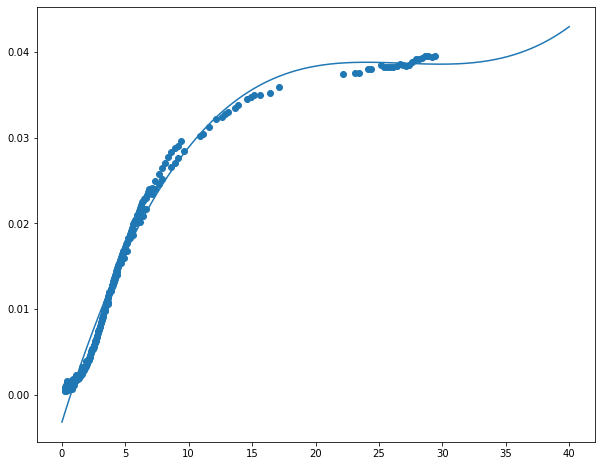

In [51]:
import pandas as pd
spline_data = dict_data["2013-12-31"].copy()
spline_data_yt = pd.DataFrame((spline_data["ttm"], spline_data["ytm"]))
spline_data_yt = spline_data_yt.T
spline_data_yt = spline_data_yt.sort_values(by=0)

from scipy.interpolate import splev, splrep
from scipy import interpolate
x_spline = (spline_data_yt[0]/365).to_numpy()
y_spline = spline_data_yt[1].to_numpy()

# use bc_type = 'natural' adds the constraints as we described above
f = splrep(x_spline, y_spline, s=2)
x_spline_date = TimeResultVec
y_solved_spline_exp = splev(x_spline_date, f, der=0)
plt.figure(figsize = (10,8))
plt.plot(x_spline_date, y_solved_spline_exp)
plt.scatter(x_spline, y_spline)

g_solved_spline_exp = nelsonsiegelsvensson.convert_y_to_g(y_solved_spline_exp, x_spline_date)
# plt.plot(x_spline_date, g_x_spline)

(0.0, 0.05)

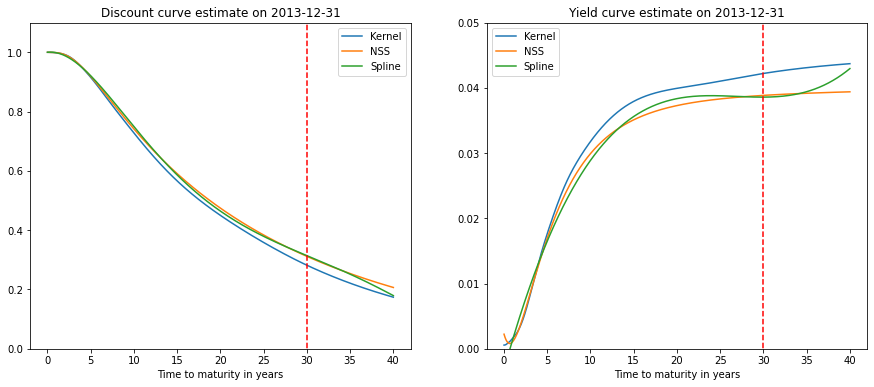

In [57]:

fig = plt.figure(figsize=(15, 6))
ax, ax_1 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)


ax.plot(np.arange(1,1+N2)/365, dict_fit_exp['g_solved'][:N2], label='Kernel')
ax.plot(np.arange(1,1+N2)/365, g_solved_nss_exp, label='NSS')
ax.plot(np.arange(1,1+N2)/365, g_solved_spline_exp, label='Spline')
ax.vlines(30, ymin=-0.5,ymax=1.5, color = "red", linestyles="dashed")

ax_1.plot(np.arange(1,1+N2)/365, dict_fit_exp['y_solved'][:N2], label='Kernel')
ax_1.plot(np.arange(1,1+N2)/365, y_solved_nss_exp, label='NSS')
ax_1.plot(np.arange(1,1+N2)/365, y_solved_spline_exp, label='Spline')
ax_1.vlines(30, ymin=-0.5,ymax=1.5,  color = "red", linestyles="dashed")

ax.legend()
ax_1.legend()
ax.set_title('Discount curve estimate on {}'.format(date))
ax_1.set_title('Yield curve estimate on {}'.format(date))
ax.set_xlabel('Time to maturity in years')
ax_1.set_xlabel('Time to maturity in years')
ax.set_ylim(0,1.1)
ax_1.set_ylim(0,0.05)

# Simulation

(0.0, 6.0)

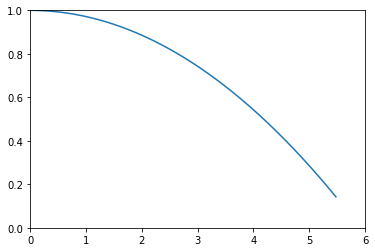

In [9]:
# true discount curve is y = 1/(1+x/365)
# simulation years around 5 2000 days and sample 100 bounds
# sample 10 times for cash flow and each cash flow is in [100,200]
# error term is normal
# cash flow is sampled around 
simu_days1 = np.arange(2000) +1
# simu_g = np.exp(-simu_days1/365)/(simu_days1/365)**(1/200)
simu_g = - (-simu_days1/365)**(2)/35 +1
# simu_g = np.exp(- simu_days1/365)
simu_y = -np.log(simu_g)/(simu_days1/365)
plt.plot(simu_days1/365,simu_g)
plt.ylim(0,1)
plt.xlim(0,6)

(0.0, 6.0)

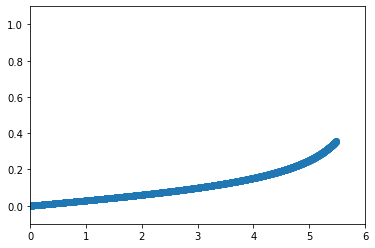

In [10]:
plt.scatter(simu_days1/365,simu_y)
plt.ylim(-0.1,1.1)
plt.xlim(0,6)

In [66]:
simu_cash_full = np.zeros((2000,200))
# simu_days_full = 

In [67]:
np.random.seed(5275)

simu_days_short = np.random.randint(1,501,(10,50))
simu_days_short2 = np.random.randint(1,1001,(10,50))
simu_days_long2 = np.random.randint(1,1501,(10,50))
simu_days_long = np.random.randint(1,2001,(10,50))
simu_days = np.hstack((simu_days_short,simu_days_long,simu_days_short2,simu_days_long2))
simu_days_sort = np.sort(simu_days, axis=0)
simu_cash = np.random.randint(100,201,(10,200))
simu_error = np.random.normal(0,2,200)

In [68]:
for i in range(200):
    simu_cash_full[simu_days_sort[:,i] -1 ,i] = simu_cash[:,i]

In [69]:
simu_dailyg =  - (-simu_days_sort/365)**(2)/35 +1
simu_price = np.diag(simu_dailyg.T@simu_cash) + simu_error

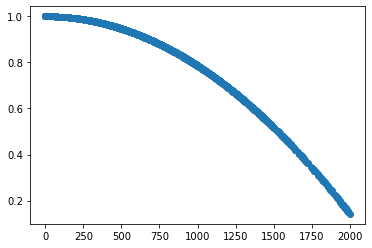

In [70]:
plt.scatter(simu_days_sort.reshape(-1,),simu_dailyg.reshape(-1,))

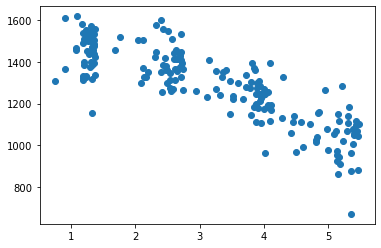

In [71]:
plt.scatter(simu_days_sort[9,]/365, simu_price)

In [72]:
### settings
# kernel hyper-parameters
alpha=0.05
delta=0.00
# delta=0.5
# max time to maturity in days
N=2000

K_simu=kr_model.generate_kernel_matrix(alpha, delta, N, N)

In [73]:
simu_data={}

# load price vector and cashflow matrix
B=simu_price
C=simu_cash_full.T
M=B.shape[0]

# get _ytm and _duration
_ytm, _dur=np.zeros(M), np.zeros(M) # _ytm and _duration
_ttm = np.zeros(M) # time to maturity in days
for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    _ytm[i], _dur[i] = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1], time_to_cashflow_inday, B[i])
    _ttm[i] = max(time_to_cashflow_inday)

# get inverse of weights for fitting
# weights w is computed as w=1/_invw
_invw=(_dur*B)**2*M

simu_data={'B':B, 'C':C, '_ytm':_ytm, '_dur':_dur, '_ttm':_ttm, '_invw':_invw}


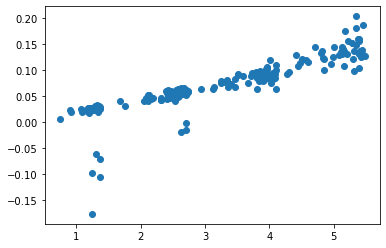

In [74]:
plt.scatter(simu_data["_ttm"]/365,simu_data["_ytm"])

In [75]:
### fit KR model on example dates

# KR ridge penalty term 
ridge=1 #lambda

simu_fit={}
for date in example_dates:
    
    simu_fit=kr_model.KR(C=simu_data['C'], # cashflow matrix
                         B=simu_data['B'], # price vector
                         ridge=ridge, # ridge hyper-parameter
                         inv_w=simu_data['_invw'], # inverse of the weighting vector
                         K=K_simu # kernel matrix
                        )
                               

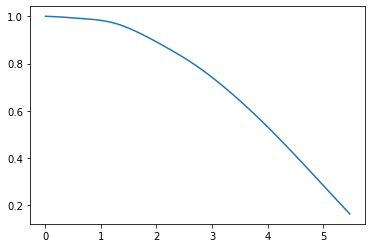

In [76]:
plt.plot(np.arange(1,2001)/365, simu_fit["g_solved"])

In [79]:
simu_fitted_price = []
for i in range(200):
    simu_fitted_price.append(simu_fit["g_solved"][simu_days_sort[:,i] - 1]@simu_cash[:,i])

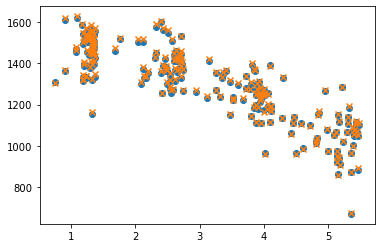

In [84]:
plt.scatter(simu_days_sort[9,]/365, simu_price)
plt.scatter(simu_data["_ttm"]/365, simu_fitted_price, marker="x")

### NSS

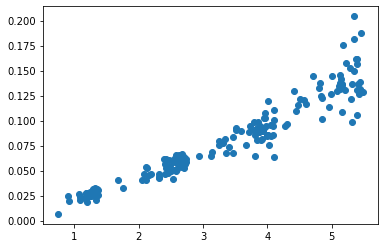

In [91]:
TimeVec = simu_data["_ttm"][simu_data["_ytm"] >= 0]/365
YieldVec = simu_data["_ytm"][simu_data["_ytm"] >= 0]
plt.scatter(TimeVec, YieldVec)

In [ ]:
import matplotlib.pyplot as plt
import nelsonsiegelsvensson

TimeVec = simu_data["_ttm"][simu_data["_ytm"] >= 0]/365
YieldVec = simu_data["_ytm"][simu_data["_ytm"] >= 0]
beta0   = 0.1 # initial guess
beta1   = 0.1 # initial guess
beta2   = 0.1 # initial guess
beta3   = 0.1 # initial guess
lambda0 = 1 # initial guess
lambda1 = 1 # initial guess

max_ttm = int(max(simu_data["_ttm"]))
# date needed for predict
TimeResultVec = np.arange(1,1+max_ttm)/365
# TimeResultVec = dict_data["2013-12-31"]["ttm"]/365 # Maturities for yields that we are interested in

## Implementation
OptiParam = nelsonsiegelsvensson.NSSMinimize2(beta0, beta1, beta2, beta3, lambda0, lambda1, TimeVec, YieldVec) # The Nelder-Mead simplex algorithem is used to find the parameters that result in a curve with the minimum residuals compared to the market data.

# Print the yield curve with optimal parameter to compare with the data provided
y_simu_nss = nelsonsiegelsvensson.NelsonSiegelSvansson(TimeResultVec, OptiParam[0], OptiParam[1], OptiParam[2], OptiParam[3], OptiParam[4], OptiParam[5])

g_simu_nss = nelsonsiegelsvensson.convert_y_to_g(y_simu_nss, TimeResultVec)
# plt.scatter(TimeResultVec, g_x)
plt.scatter(TimeResultVec, y_simu_nss)
plt.scatter(simu_data["_ttm"]/365,simu_data["_ytm"])
plt.show()

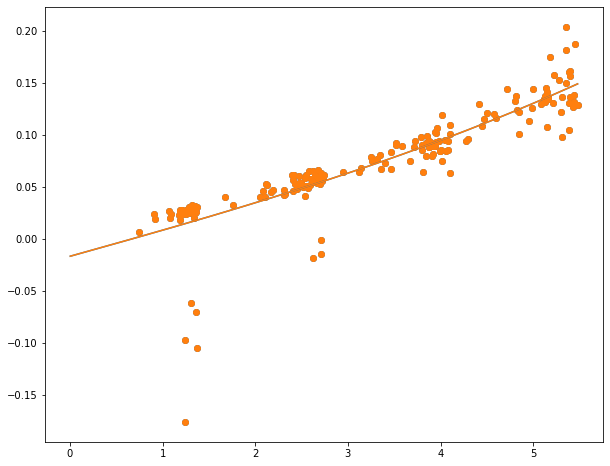

In [86]:
import pandas as pd
import copy
spline_data = copy.deepcopy(simu_data)
spline_data_yt = pd.DataFrame((spline_data["_ttm"], spline_data["_ytm"]))
spline_data_yt = spline_data_yt.T
spline_data_yt = spline_data_yt.sort_values(by=0)
from scipy.interpolate import splev, splrep
from scipy import interpolate
x_spline = (spline_data_yt[0]/365).to_numpy()
y_spline = spline_data_yt[1].to_numpy()

# use bc_type = 'natural' adds the constraints as we described above
f = splrep(x_spline, y_spline, s=2)
x_spline_date = TimeResultVec
y_simu_spline = splev(x_spline_date, f, der=0)
plt.figure(figsize = (10,8))
plt.plot(x_spline_date, y_simu_spline)
plt.scatter(x_spline, y_spline)

g_simu_spline = nelsonsiegelsvensson.convert_y_to_g(y_simu_spline, x_spline_date)
plt.plot(x_spline_date, y_simu_spline)
plt.scatter(simu_data["_ttm"]/365,simu_data["_ytm"])